#Analiza sentymentu (śmieszny / zwykły tekst)

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [1]:
import torch

SEED = 42
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [2]:
from torchtext.data.utils import get_tokenizer
from torch.utils.data import random_split
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import time

In [3]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Semestr III/ZUM/humor_detection_dataset/dataset.csv"
df = pd.read_csv(path)
df.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    200000 non-null  object
 1   humor   200000 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 1.7+ MB


In [4]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Eksploracja danych

In [ ]:
# Data exploration
print("Dataset sample:")
print(df.sample(5))
print()
print("Data shape:")
print(df.shape)
print()
print("Columns:")
print(df.columns)
print()
print("Null values count:\n",df.isnull().sum())
print()
print("Dataset description:")
print(df.describe())

Dataset sample:
                                                     text  humor
150783  Brexit crisis tops off rough stretch in obama'...  False
191020     What do you call crystal clear urine? 1080-pee   True
116364  Rachel maddow wonders: would we really be bett...  False
12736   After highs and lows of 2016, make 2017 a bett...  False
135105  Police search chris brown's home after woman c...  False

Data shape:
(200000, 2)

Columns:
Index(['text', 'humor'], dtype='object')

Null values count:
 text     0
humor    0
dtype: int64

Dataset description:
                                                     text   humor
count                                              200000  200000
unique                                             200000       2
top     Joe biden rules out 2020 bid: 'guys, i'm not r...   False
freq                                                    1  100000


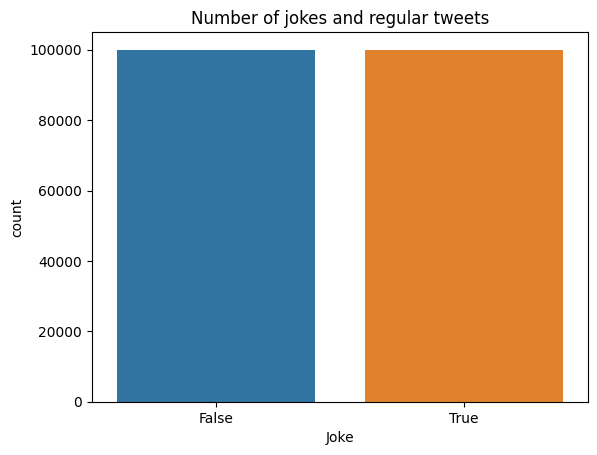

In [ ]:
#Class distribution
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(df,x='humor')
plt.xlabel('Joke')
plt.title('Number of jokes and regular tweets')
plt.show()

### Przygotowanie danych

In [ ]:

# 2. Przygotowanie danych (jeśli wymagane)
missing_indexes = df.index[~df.index.isin(range(len(df)))]

# Brakujące indexy
if len(missing_indexes) > 0:
    print(f"Missing index labels: {missing_indexes}")
else:
    print("No missing index labels")

No missing index labels


In [5]:
records = df.to_records(index=False)
data_list = list(records)
data_list[-1]

("An irish man walks on the street and ignores a bar... muahahaha, like that's possible!", True)

In [6]:
tokenizer = get_tokenizer('spacy', 'en_core_web_sm')

def yield_tokens(data_iter):
    for (text, label) in data_iter:
        yield tokenizer(text)

In [7]:
# dzielimy dane na train i test
split_ratio = 0.2
n_train = len(data_list)
n_test = int(n_train * split_ratio)
n_train = n_train - n_test
train_data, test_data = random_split(data_list, [n_train, n_test])

In [8]:
# sami wydzielimy część na walidację odcinając 50% testu
validation_ratio = 0.5
n_test = len(test_data)
n_val = int(n_test * validation_ratio)
n_test = n_test - n_val
val_data, test_data = random_split(test_data, [n_val, n_test])

In [ ]:
train_data[0]

('What do you call a mexican ghost? a juanting.', True)

In [9]:
MAX_TOKENS = 25000
train_iter = iter(train_data)
vocab = build_vocab_from_iterator(
    yield_tokens(train_iter),
    specials=['<unk>'],
    max_tokens=MAX_TOKENS)
vocab.set_default_index(vocab['<unk>'])

In [10]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == True else 0

def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for text_label in batch:
        label_list.append(label_pipeline(text_label[1]))
        processed_text = torch.tensor(text_pipeline(text_label[0]), dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.float32)
    lengths = torch.tensor(lengths, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)
    return label_list, text_list, lengths

In [11]:
# w końcu ustalamy rozmiar batchy i tworzymy 3 dataloadery do wrzucania danych do modelu
batch_size = 64
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

In [12]:
def count_parameters(model):
 return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
# Funkcja accuracy
def accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [14]:
texts=["What kind of candy do astronauts like? Mars bars.",
       "The weather is fine today. Clear sky and no clouds.",
       "What falls, but never needs a bandage? The rain.",
       "president biden will have a speech before congres on Friday",
       "Anna study for her last exam in this semester. She wants to pass with best grade",
       "that was so bad"]

In [15]:
def process_for_prediction(texts):
  text_list, lengths = [], []
  for text in texts:
      processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
      text_list.append(processed_text)
      lengths.append(processed_text.size(0))
  lengths = torch.tensor(lengths, dtype=torch.int64)
  text_list = pad_sequence(text_list, batch_first=True)
  return text_list, lengths

### LSTM

In [ ]:
# 6. Zbuduj model LSTM w PyTorch
class SentimentAnalysisLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted=False) # text_lengths.to('cpu')
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden.squeeze(0))


In [ ]:
vocab['<pad>']

0

In [ ]:
# Hyperparametery
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = vocab['<pad>']

# Inicjalizacja modelu
modelLSTM = SentimentAnalysisLSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

In [ ]:
print(f'Model ma {count_parameters(modelLSTM):,} parametrów')

Model ma 4,810,657 parametrów


In [ ]:
# 7. Zdefiniuj funkcję straty i optymalizator
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(modelLSTM.parameters())
optimizer = optim.SGD(modelLSTM.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# modelLSTM = modelLSTM.to(device)
# criterion = criterion.to(device)

In [ ]:
# Training loop
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in iterator:
        humor, text, lengths = batch
        predictions = model(text, lengths).squeeze(1)
        loss = criterion(predictions, humor)
        acc = accuracy(predictions, humor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

  # Evaluation loop
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in iterator:
            humor, text, lengths = batch
            predictions = model(text, lengths).squeeze(1)
            loss = criterion(predictions, humor)
            acc = accuracy(predictions, humor)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [ ]:
# Trenowanie modelu
N_EPOCHS = 5
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train(modelLSTM, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(modelLSTM, val_dataloader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(modelLSTM.state_dict(), 'lstm-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc * 100:.2f}%')


### CNN

In [16]:
class SentimentAnalysisCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs, embedding_dim)) for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)
        conved = [nn.functional.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [nn.functional.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)

In [17]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = vocab['<pad>']

In [18]:
modelCNN= SentimentAnalysisCNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

print(f'Model ma {count_parameters(modelCNN):,} parametrów')

Model ma 2,620,601 parametrów


In [ ]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(modelLSTM.parameters())
optimizer = optim.SGD(modelCNN.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# modelCNN = modelCNN.to(device)
# criterion = criterion.to(device)

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for labels, text, text_lengths in iterator:
        optimizer.zero_grad()
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, labels)
        acc = accuracy(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for labels, text, text_lengths in iterator:
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)
            acc = accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
N_EPOCHS = 5
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(modelCNN, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(modelCNN, val_dataloader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(modelCNN.state_dict(), 'cnn-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 3m 1s
	Train Loss: 0.614 | Train Acc: 65.63%
	 Val. Loss: 0.469 |  Val. Acc: 86.09%
Epoch: 02 | Epoch Time: 3m 14s
	Train Loss: 0.443 | Train Acc: 80.53%
	 Val. Loss: 0.318 |  Val. Acc: 89.85%
Epoch: 03 | Epoch Time: 3m 28s
	Train Loss: 0.363 | Train Acc: 85.20%
	 Val. Loss: 0.274 |  Val. Acc: 90.28%
Epoch: 04 | Epoch Time: 3m 8s
	Train Loss: 0.329 | Train Acc: 87.02%
	 Val. Loss: 0.255 |  Val. Acc: 90.70%
Epoch: 05 | Epoch Time: 2m 50s
	Train Loss: 0.308 | Train Acc: 88.08%
	 Val. Loss: 0.244 |  Val. Acc: 91.06%


In [19]:
model_save_name = 'cnn-model.pt'
model_path = f"/content/drive/MyDrive/Semestr III/ZUM/humor_detection_dataset/{model_save_name}"
torch.save(modelCNN.state_dict(), model_path)

In [20]:
model_save_name = 'cnn-model.pt'
model_path = f"/content/drive/MyDrive/Semestr III/ZUM/humor_detection_dataset/{model_save_name}"
modelCNN.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [25]:
predictions = modelCNN(process_for_prediction(texts)[0])
predictions = torch.sigmoid(predictions)

In [26]:
for text, prediction in zip(texts,predictions):
  if prediction < 0.5:
    print(text + "    is no joke")
  else:
    print(text+ "   is a joke")

What kind of candy do astronauts like? Mars bars.   is a joke
The weather is fine today. Clear sky and no clouds.   is a joke
What falls, but never needs a bandage? The rain.   is a joke
president biden will have a speech before congres on Friday    is no joke
Anna study for her last exam in this semester. She wants to pass with best grade   is a joke
that was so bad    is no joke


### RNN z word embedingiem

In [27]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class RNNwithPretrainedWordEmbeddings(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pretrained_embeddings):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings) #nie będziemi sami trenowali wag tylko ładujemy te już wytrenowane
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        # pakujemy sekwencje
        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_embedded)
        # rozpakowujemy wyjście
        output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)
        return self.fc(hidden.squeeze(0))

In [28]:
from torchtext.vocab import GloVe

glove = GloVe(name='6B', dim=100)  # Korzystamy z wektorów 100-wymiarowych z GloVe

.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
100%|█████████▉| 399999/400000 [00:28<00:00, 14003.26it/s]


In [29]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

embedding_matrix = torch.zeros((INPUT_DIM, EMBEDDING_DIM))

# dodajemy warunek jeśli vocab jest obiektem Vocab z torchtext
for i, word in enumerate(vocab.get_itos()):  # get_itos() zwraca listę tokenów w słowniku vocab
    if word in glove.stoi:
        embedding_matrix[i] = glove.vectors[glove.stoi[word]]
    # w przeciwnym razie zainicjalizujemy embedding jako wektor zer


modelRNNwithPretrainedWordEmbeddings = RNNwithPretrainedWordEmbeddings(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, embedding_matrix)

In [30]:
print(f'Model ma {count_parameters(modelRNNwithPretrainedWordEmbeddings):,} parametrów')

Model ma 91,905 parametrów


In [ ]:
optimizer = optim.SGD(modelRNNwithPretrainedWordEmbeddings.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelRNNwithPretrainedWordEmbeddings = modelRNNwithPretrainedWordEmbeddings.to(device)
criterion = criterion.to(device)

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in iterator:
        labels, texts, lengths = batch
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()

        predictions = model(texts, lengths).squeeze(1)
        loss = criterion(predictions, labels)
        acc = accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for batch in iterator:
            labels, texts, lengths = batch
            texts, labels = texts.to(device), labels.to(device)

            predictions = model(texts, lengths).squeeze(1)
            loss = criterion(predictions, labels)
            acc = accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [ ]:
N_EPOCHS = 5
best_valid_loss = float('inf')
model_save_name = 'rnn-with-embeddings-model.pt'
model_path = f"/content/drive/MyDrive/Semestr III/ZUM/humor_detection_dataset/{model_save_name}"

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train(modelRNNwithPretrainedWordEmbeddings, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(modelRNNwithPretrainedWordEmbeddings, val_dataloader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(modelRNNwithPretrainedWordEmbeddings.state_dict(), 'rnn-with-embeddings-model.pt')
        torch.save(modelRNNwithPretrainedWordEmbeddings.state_dict(), model_path)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Epoch: 01 | Epoch Time: 0m 33s
	Train Loss: 0.575 | Train Acc: 76.65%
	 Val. Loss: 0.458 |  Val. Acc: 83.11%
Epoch: 02 | Epoch Time: 0m 37s
	Train Loss: 0.300 | Train Acc: 88.36%
	 Val. Loss: 0.222 |  Val. Acc: 91.46%
Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 0.205 | Train Acc: 91.91%
	 Val. Loss: 0.196 |  Val. Acc: 92.51%
Epoch: 04 | Epoch Time: 0m 24s
	Train Loss: 0.189 | Train Acc: 92.58%
	 Val. Loss: 0.184 |  Val. Acc: 93.00%
Epoch: 05 | Epoch Time: 0m 29s
	Train Loss: 0.181 | Train Acc: 92.95%
	 Val. Loss: 0.179 |  Val. Acc: 93.15%


In [33]:
model_save_name = 'rnn-with-embeddings-model.pt'
model_path = f"/content/drive/MyDrive/Semestr III/ZUM/humor_detection_dataset/{model_save_name}"
modelRNNwithPretrainedWordEmbeddings.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [34]:
predictions = modelRNNwithPretrainedWordEmbeddings(process_for_prediction(texts)[0],process_for_prediction(texts)[1])
predictions = torch.sigmoid(predictions)

In [35]:
for text, prediction in zip(texts,predictions):
  if prediction < 0.5:
    print(text + "    is no joke")
  else:
    print(text+ "   is a joke")

What kind of candy do astronauts like? Mars bars.   is a joke
The weather is fine today. Clear sky and no clouds.   is a joke
What falls, but never needs a bandage? The rain.   is a joke
president biden will have a speech before congres on Friday    is no joke
Anna study for her last exam in this semester. She wants to pass with best grade    is no joke
that was so bad    is no joke


### LSTM z word embedingiem

In [36]:
class SentimentAmalysisLSTMwithPretrainedWordEmbeddings(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx, pretrained_embeddings):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.embedding.weight.data.copy_(pretrained_embeddings)
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden.squeeze(0))

In [37]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = vocab['<pad>']

In [38]:
embedding_matrix = torch.zeros((INPUT_DIM, EMBEDDING_DIM))

# dodajemy warunek jeśli vocab jest obiektem Vocab z torchtext
for i, word in enumerate(vocab.get_itos()):  # get_itos() zwraca listę tokenów w słowniku vocab
    if word in glove.stoi:
        embedding_matrix[i] = glove.vectors[glove.stoi[word]]
    # w przeciwnym razie zainicjalizujemy embedding jako wektor zer

In [39]:
modelLSTMwithPretrainedWordEmbeddings = SentimentAmalysisLSTMwithPretrainedWordEmbeddings(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX, embedding_matrix)

print(f'Model ma {count_parameters(modelLSTMwithPretrainedWordEmbeddings):,} parametrów')

Model ma 2,310,657 parametrów


In [ ]:
optimizer = optim.SGD(modelLSTMwithPretrainedWordEmbeddings.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# modelLSTMwithPretrainedWordEmbeddings = modelLSTMwithPretrainedWordEmbeddings.to(device)
# criterion = criterion.to(device)

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for labels, text, text_lengths in iterator:
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, labels)
        acc = accuracy(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for labels, text, text_lengths in iterator:
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, labels)
            acc = accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
N_EPOCHS = 5
best_valid_loss = float('inf')
model_save_name = 'lstm-with-embeddings-model.pt'
model_path = f"/content/drive/MyDrive/Semestr III/ZUM/humor_detection_dataset/{model_save_name}"

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(modelLSTMwithPretrainedWordEmbeddings, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(modelLSTMwithPretrainedWordEmbeddings, val_dataloader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(modelLSTMwithPretrainedWordEmbeddings.state_dict(), 'lstm-with-embeddings-model.pt')
        torch.save(modelRNNwithPretrainedWordEmbeddings.state_dict(), model_path)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [40]:
model_save_name = 'lstm-with-embeddings-model.pt'
model_path = f"/content/drive/MyDrive/Semestr III/ZUM/humor_detection_dataset/{model_save_name}"
modelLSTMwithPretrainedWordEmbeddings.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [56]:
predictions = modelLSTMwithPretrainedWordEmbeddings(process_for_prediction(texts)[0],process_for_prediction(texts)[1])
predictions = torch.sigmoid(predictions)

In [59]:
print(predictions)

tensor([[0.5259],
        [0.5218],
        [0.5270],
        [0.4846],
        [0.4901],
        [0.5211]], grad_fn=<SigmoidBackward0>)


In [60]:
for text, prediction in zip(texts,predictions):
  if prediction < 0.5:
    print(text + "    is no joke")
  else:
    print(text+ "   is a joke")

What kind of candy do astronauts like? Mars bars.   is a joke
The weather is fine today. Clear sky and no clouds.   is a joke
What falls, but never needs a bandage? The rain.   is a joke
president biden will have a speech before congres on Friday    is no joke
Anna study for her last exam in this semester. She wants to pass with best grade    is no joke
that was so bad   is a joke


Fine tune Albert-Base-v2

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = 'albert-base-v2'
# model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
!pip install accelerate -U

In [ ]:
!pip install datasets -U

In [ ]:
train_data[0]

('What do you call a mexican ghost? a juanting.', True)

In [ ]:
train_df=pd.DataFrame.from_records(train_data, columns=["text","label"])
val_df=pd.DataFrame.from_records(val_data, columns=["text","label"])
test_df=pd.DataFrame.from_records(test_data, columns=["text","label"])

In [ ]:
train_df = train_df.replace([True, False],[1,0])
val_df = val_df.replace([True, False],[1,0])
test_df = test_df.replace([True, False],[1,0])

In [ ]:
from datasets import Dataset
train_ds = Dataset.from_pandas(train_df, split='train[:100%]')
print(train_ds)

Dataset({
    features: ['text', 'label'],
    num_rows: 160000
})


In [ ]:
val_ds = Dataset.from_pandas(val_df, split='val[:100%]')
print(val_ds)

Dataset({
    features: ['text', 'label'],
    num_rows: 20000
})


In [ ]:
test_ds = Dataset.from_pandas(test_df, split='test[:100%]')
print(test_ds)

Dataset({
    features: ['text', 'label'],
    num_rows: 20000
})


In [ ]:
def process(x):
  return tokenizer(x['text']) # , padding=True, truncation=True, return_tensors="pt"

train_ds = train_ds.map(process)
eval_ds = val_ds.map(process)
test_ds = test_ds.map(process)

Map:   0%|          | 0/160000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [ ]:
eval_ds[0]

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
batch_size=64
args = TrainingArguments(
    f'{model_checkpoint}_sentiment_analysis',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 5,
    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy'
)

In [ ]:

from datasets import load_metric
import numpy as np

metric = load_metric('glue', 'sst2')

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)



<ipython-input-24-beeb781b4109>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue', 'sst2')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.evaluate([train_ds[0]])

You're using a AlbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 1.1197936534881592,
 'eval_accuracy': 0.0,
 'eval_runtime': 0.8268,
 'eval_samples_per_second': 1.209,
 'eval_steps_per_second': 1.209}

In [ ]:
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.054100,0.050637,0.982500
2,0.033100,0.059635,0.984350
3,0.016600,0.068484,0.985900
4,0.006400,0.067099,0.987400
5,0.001700,0.094408,0.987400


In [ ]:
trainer.model

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [ ]:
model_save_name = 'albert-base-v2'
model_path = f"/content/drive/MyDrive/Semestr III/ZUM/humor_detection_dataset/{model_save_name}"
trainer.save_model("path_to_save")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cuda'
input_ids = inputs['input_ids'] #.to(device)
attention_mask = inputs['attention_mask'] #.to(device)
with torch.no_grad():
  outputs = model(input_ids=input_ids, attention_mask=attention_mask)
  logits = outputs.logits
  predictions = torch.argmax(logits, dim=-1)

for text, prediction in zip(texts,predictions):
  if prediction == 0:
    print(text + " is no joke")
  else:
    print(text+ " is a joke")


What kind of candy do astronauts like? Mars bars. is a joke
The weather is fine today. Clear sky and no clouds. is a joke
What falls, but never needs a bandage? The rain. is a joke
president biden will have a speech before congres on Friday is no joke
Anna study for her last exam in this semester. She wants to pass with best grade is a joke
that was so bad is no joke
